In [ ]:
# ============================================================================
# 导入所有必需的库和模块
# ============================================================================

# 基础库
import pandas as pd
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')

# 可视化
import matplotlib.pyplot as plt
import seaborn as sns

# API 和模型
from ambiguity_detection_utils import AmbiguityDetector
from ollama import Client
from prompts import DISAMBIGUATION_PROMPT_TEMPLATE, PSEUDOCODE_PROMPT_TEMPLATE

# 深度学习模型
import torch
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer

# 机器学习评估指标
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import (
    roc_auc_score, roc_curve, f1_score, 
    precision_recall_curve, auc,
    confusion_matrix, classification_report, 
    accuracy_score
)

print("所有库导入完成！")

In [ ]:
# ============================================================================
# 创建检测器和加载数据
# ============================================================================

# 创建语义歧义检测器
detector = AmbiguityDetector("semantic")

# 加载并准备数据
file_path = r"data/User Story Ambiguity Dataset_A Comprehensive Research Resource/Cornelius_2025_user_story_ambiguity_dataset.xlsx"
df_test = detector.load_and_prepare_data(file_path, create_balanced=True)

print(f"测试数据集: {len(df_test)} 个用户故事")

In [2]:
df_test.head()

,StoryID,StoryText,HasAmbiguity
0,US-C3-6636,"As a seller, I would like to track order to fi...",False
1,US-C7-12360,"As a store owner, I want to track order in ord...",False
2,US-C2-3691,"As a patient, I need to access records so that...",False
3,US-C5-9039,"As a investor, I want to handle finances in or...",True
4,US-C1-610,"As a financial advisor, I need to manage accou...",True


In [3]:
df_test.count()

StoryID         5662
StoryText       5662
HasAmbiguity    5662
dtype: int64

In [7]:
client = Client(
    host="http://2yo6159kw603.vicp.fun/",
)

In [ ]:
prompt_template = DISAMBIGUATION_PROMPT_TEMPLATE

In [9]:
# 遍历df_test中的每个StoryText，使用prompt_template进行推理，并将结果存储为列表
results = []

for index, row in df_test.iterrows():
    story_text = row['StoryText']
    formatted_prompt = prompt_template.format(REQUIREMENT=story_text)
    
    try:
        response = client.chat(model='gpt-oss:20b', messages=[
            {
                'role': 'user',
                'content': formatted_prompt,
            },
        ])
        results.append({
            'StoryID': row['StoryID'],
            'StoryText': story_text,
            'HasAmbiguity': row['HasAmbiguity'],
            'Disambiguation': response.message.content
        })
        print(f"Processed story {index + 1}/{len(df_test)}: {row['StoryID']}")
    except Exception as e:
        print(f"Error processing story {row['StoryID']}: {str(e)}")
        results.append({
            'StoryID': row['StoryID'],
            'StoryText': story_text,
            'HasAmbiguity': row['HasAmbiguity'],
            'Disambiguation': f"Error: {str(e)}"
        })

print(f"\nCompleted processing {len(results)} stories.")

Processed story 1/20: US-C3-6636
Processed story 2/20: US-C7-12360
Processed story 3/20: US-C2-3691
Processed story 4/20: US-C5-9039
Processed story 5/20: US-C1-610
Processed story 6/20: US-C7-12019
Processed story 7/20: US-C2-4089
Processed story 8/20: US-C7-11804
Processed story 9/20: US-C4-7990
Processed story 10/20: US-C2-4016
Processed story 11/20: US-C3-6940
Processed story 12/20: US-C1-2094
Processed story 13/20: US-C2-4137
Processed story 14/20: US-C6-11035
Processed story 15/20: US-C1-1481
Processed story 16/20: US-C5-9048
Processed story 17/20: US-C5-10303
Processed story 18/20: US-C3-6856
Processed story 19/20: US-C3-6326
Processed story 20/20: US-C1-1212

Completed processing 20 stories.


In [10]:
# 解析消歧结果，将每个用户故事的消歧项转换为列表格式
parsed_results = []

for result in results:
    story_id = result['StoryID']
    story_text = result['StoryText']
    disambiguation_text = result['Disambiguation']
    
    # 解析消歧项
    disambiguations = []
    if disambiguation_text.startswith('Disambiguations:'):
        # 移除开头的'Disambiguations:'
        content = disambiguation_text[len('Disambiguations:'):].strip()
        # 按行分割
        lines = content.split('\n')
        for line in lines:
            line = line.strip()
            # 检查是否是以数字开头的消歧项
            if line and (line.startswith('1. ') or line.startswith('2. ') or line.startswith('3. ') 
                         or line.startswith('4. ') or line.startswith('5. ') or line.startswith('6. ') 
                         or line.startswith('7. ') or line.startswith('8. ') or line.startswith('9. ') 
                         or line.startswith('10. ')):
                # 提取消歧项内容（去掉序号）
                disambiguation = line.split('. ', 1)[1].strip()
                disambiguations.append(disambiguation)
    
    parsed_results.append({
        'StoryID': story_id,
        'StoryText': story_text,
        'Disambiguations': disambiguations
    })

# 显示解析后的结果
for parsed_result in parsed_results:
    print(f"用户故事: {parsed_result['StoryID']}")
    print(f"故事文本: {parsed_result['StoryText']}")
    print("消歧项列表:")
    for i, disambiguation in enumerate(parsed_result['Disambiguations'], 1):
        print(f"  {i}. {disambiguation}")
    print()

用户故事: US-C3-6636
故事文本: As a seller, I would like to track order to find desired items with detailed specifications and comprehensive requirements
消歧项列表:
  1. As a seller, I want a dashboard that shows the current status of each order (processing, shipped, delivered) and lists every item in the order with its product specifications so that I can quickly verify that the items meet the customer’s expectations and my inventory records.
  2. As a seller, I want the ability to search within all open orders for items that match specific detailed specifications (e.g., size, color, material) so that I can identify which orders contain the products I need to restock or highlight to customers.
  3. As a seller, I want automated alerts when an order contains an item lacking required detailed specifications or missing compliance documentation so that I can address the issue before shipment and avoid returns.
  4. As a seller, I want a real‑time inventory tracker that cross‑references order items wi

In [11]:
# 过滤掉澄清项为空的结果
parsed_results_filtered = [result for result in parsed_results if result['Disambiguations']]

print(f"原始结果数量: {len(parsed_results)}")
print(f"过滤后结果数量: {len(parsed_results_filtered)}")
print(f"已过滤掉的结果: {len(parsed_results) - len(parsed_results_filtered)}")

# 更新parsed_results为过滤后的结果
parsed_results = parsed_results_filtered

print("\n过滤完成，现在parsed_results只包含有澄清项的结果")

原始结果数量: 20
过滤后结果数量: 20
已过滤掉的结果: 0

过滤完成，现在parsed_results只包含有澄清项的结果


In [ ]:
# 1. 加载预训练的BERT模型和分词器
model_name = "rambodazimi/bert-base-uncased-finetuned-FFT-QQP"
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

# 设置设备（GPU或CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
bert_model.eval()  # 设置为评估模式

print(f"BERT模型已加载到 {device}")
print(f"模型名称: {model_name}")

In [14]:
# 2. 定义获取句子嵌入的函数
def get_sentence_embedding(text, tokenizer, model, device, max_length=512):
    """
    获取文本的BERT嵌入向量
    
    参数:
        text: 输入文本
        tokenizer: BERT分词器
        model: BERT模型
        device: 计算设备 (cuda or cpu)
        max_length: 最大文本长度
    
    返回:
        embedding: 句子嵌入向量 (1, 768)
    """
    # 将文本转换为模型可接受的输入格式
    inputs = tokenizer(
        text, 
        return_tensors="pt", 
        padding=True, 
        truncation=True, 
        max_length=max_length
    )
    
    # 将输入移到相同的设备上
    inputs = {key: val.to(device) for key, val in inputs.items()}
    
    # 不计算梯度，加快推理速度
    with torch.no_grad():
        outputs = model(**inputs)
    
    # 对最后一个隐藏层的所有标记向量求平均
    embedding = torch.mean(outputs.last_hidden_state, dim=1)
    
    return embedding.cpu().numpy()

print("get_sentence_embedding 函数已定义")

get_sentence_embedding 函数已定义


In [15]:
# 3. 定义计算两个文本相似度的函数
def compute_pairwise_similarity(text1, text2, tokenizer, model, device):
    """
    计算两个文本之间的语义相似度（余弦相似度）
    
    注意：按照论文中的说法，相似度计算应该是非对称的（考虑顺序），
    但这里使用余弦相似度是对称的。如果需要使用BERT QOP微调模型的非对称相似度，
    需要使用特定的相似度模型。
    
    参数:
        text1: 第一个文本
        text2: 第二个文本
        tokenizer: BERT分词器
        model: BERT模型
        device: 计算设备
    
    返回:
        similarity: 相似度得分 (0-1)
    """
    # 获取两个文本的嵌入向量
    embedding1 = get_sentence_embedding(text1, tokenizer, model, device)
    embedding2 = get_sentence_embedding(text2, tokenizer, model, device)
    
    # 计算余弦相似度
    similarity = cosine_similarity(embedding1, embedding2)[0][0]
    
    return similarity

print("compute_pairwise_similarity 函数已定义")

compute_pairwise_similarity 函数已定义


In [16]:
# 4. 定义计算 Clarification Score 的函数（核心方法）
def calculate_clarification_score(clarifications, tokenizer, model, device):
    """
    计算澄清批次的歧义分数
    
    公式: g(C_i^(q)) = ∑_{(c_ij, c_ij') ∈ C_i^(q) × C_i^(q)} (1 - sim(c_ij, c_ij'))
    
    该分数衡量澄清之间的语义分散程度。高分表示澄清之间差异大，
    说明原始查询具有高度歧义。低分表示澄清之间相似，说明原始查询较为明确。
    
    参数:
        clarifications: 澄清文本列表
        tokenizer: BERT分词器
        model: BERT模型
        device: 计算设备
    
    返回:
        score: 澄清分数（高分表示高歧义）
        similarity_matrix: 相似度矩阵 (n, n)
    """
    n = len(clarifications)
    
    if n < 2:
        # 如果少于2个澄清，无法计算分数
        return 0.0, np.array([[1.0]])
    
    # 1. 获取所有澄清的嵌入向量
    embeddings = []
    for clarification in clarifications:
        embedding = get_sentence_embedding(clarification, tokenizer, model, device)
        embeddings.append(embedding)
    
    embeddings = np.vstack(embeddings)  # (n, 768)
    
    # 2. 计算所有澄清对的相似度矩阵
    similarity_matrix = cosine_similarity(embeddings)  # (n, n)
    
    # 3. 计算分数：所有非对角线相似度倒数和
    score = 0.0
    pair_count = 0
    
    for i in range(n):
        for j in range(n):
            if i != j:  # 不包括自身相似度
                dissimilarity = 1 - similarity_matrix[i][j]
                score += dissimilarity
                pair_count += 1
    
    return score, similarity_matrix

print("calculate_clarification_score 函数已定义")

calculate_clarification_score 函数已定义


In [ ]:
# 5. 处理解析后的结果，计算每个用户故事的 Clarification Score
clarification_scores = []

for idx, parsed_result in enumerate(parsed_results):
    story_id = parsed_result['StoryID']
    story_text = parsed_result['StoryText']
    disambiguations = parsed_result['Disambiguations']
    
    # 如果有澄清项，计算分数；否则分数为0
    if len(disambiguations) > 1:
        score, similarity_matrix = calculate_clarification_score(
            disambiguations, 
            tokenizer, 
            bert_model, 
            device
        )
    else:
        score = 0.0
        similarity_matrix = np.array([[1.0]])
    
    clarification_scores.append({
        'StoryID': story_id,
        'StoryText': story_text,
        'NumClarifications': len(disambiguations),
        'ClarificationScore': score,
        'AmbiguityLevel': 'High' if score > 5 else ('Medium' if score > 2 else 'Low')
    })
    
    print(f"已处理 {idx + 1}/{len(parsed_results)}: {story_id}")
    print(f"  澄清数: {len(disambiguations)}, 分数: {score:.4f}, 歧义级别: {clarification_scores[-1]['AmbiguityLevel']}")

# 创建DataFrame用于分析
scores_df = pd.DataFrame(clarification_scores)
print(f"\n完成处理 {len(clarification_scores)} 个用户故事")
print("\n澄清分数统计:")
print(scores_df[['NumClarifications', 'ClarificationScore', 'AmbiguityLevel']].describe())

In [ ]:
# 6. 可视化分析结果
# 设置图表风格
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# 创建子图
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Clarification Score 分布直方图
axes[0, 0].hist(scores_df['ClarificationScore'], bins=15, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Clarification Score')
axes[0, 0].set_ylabel('频率')
axes[0, 0].set_title('Clarification Score 分布')
axes[0, 0].axvline(scores_df['ClarificationScore'].mean(), color='red', linestyle='--', label=f'平均值: {scores_df["ClarificationScore"].mean():.2f}')
axes[0, 0].legend()

# 2. 澄清数量 vs 分数散点图
axes[0, 1].scatter(scores_df['NumClarifications'], scores_df['ClarificationScore'], alpha=0.6, s=100)
axes[0, 1].set_xlabel('澄清数量')
axes[0, 1].set_ylabel('Clarification Score')
axes[0, 1].set_title('澄清数量 vs 分数')
axes[0, 1].grid(True, alpha=0.3)

# 3. 歧义级别分布
ambiguity_counts = scores_df['AmbiguityLevel'].value_counts()
axes[1, 0].bar(ambiguity_counts.index, ambiguity_counts.values, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('歧义级别')
axes[1, 0].set_ylabel('数量')
axes[1, 0].set_title('歧义级别分布')
for i, v in enumerate(ambiguity_counts.values):
    axes[1, 0].text(i, v + 0.1, str(v), ha='center', va='bottom')

# 4. 评分箱线图（按歧义级别）
order = ['Low', 'Medium', 'High']
scores_df_sorted = scores_df.copy()
scores_df_sorted['AmbiguityLevel'] = pd.Categorical(scores_df_sorted['AmbiguityLevel'], categories=order, ordered=True)
sns.boxplot(data=scores_df_sorted, x='AmbiguityLevel', y='ClarificationScore', ax=axes[1, 1])
axes[1, 1].set_xlabel('歧义级别')
axes[1, 1].set_ylabel('Clarification Score')
axes[1, 1].set_title('各歧义级别的分数分布')

plt.tight_layout()
plt.savefig('clarification_score_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("分析结果已保存到 clarification_score_analysis.png")

In [ ]:
# 8. 计算 AUROC 和 F1 分数用于评估歧义检测性能
# 合并 df_test 的真实标签和 scores_df 的预测分数
# 创建一个映射字典，将 StoryID 与 HasAmbiguity 对应
true_labels_dict = dict(zip(df_test['StoryID'], df_test['HasAmbiguity']))

# 为 scores_df 添加真实标签
scores_df['TrueLabel'] = scores_df['StoryID'].map(true_labels_dict)

# 移除没有真实标签的行
scores_df_with_labels = scores_df.dropna(subset=['TrueLabel'])

print(f"用于评估的样本数: {len(scores_df_with_labels)}")
print(f"真实标签分布:")
print(scores_df_with_labels['TrueLabel'].value_counts())
print()

# 准备数据
y_true = scores_df_with_labels['TrueLabel'].astype(int).values
y_scores = scores_df_with_labels['ClarificationScore'].values

# 1. 计算 AUROC
auroc = roc_auc_score(y_true, y_scores)
print(f"消歧方法 - AUROC: {auroc:.4f}")

# 获取ROC曲线的FPR和TPR
fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)

# 2. 寻找最优的阈值（使用约登指数）
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = roc_thresholds[optimal_idx]

print(f"最优阈值（基于约登指数）: {optimal_threshold:.4f}")

# 3. 使用最优阈值进行二分类
y_pred = (y_scores >= optimal_threshold).astype(int)

# 4. 计算 F1 分数
f1 = f1_score(y_true, y_pred)
print(f"消歧方法 - F1 Score: {f1:.4f}")

# 5. 计算其他评估指标（用于可视化和后续分析，但不在主要输出中突出）
accuracy = accuracy_score(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

# 6. Precision-Recall 曲线
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall_vals, precision_vals)

print("\n" + "="*50)
print(f"\n总结:")
print(f"  AUROC: {auroc:.4f}")
print(f"  F1 Score: {f1:.4f}\n")
print("="*50)

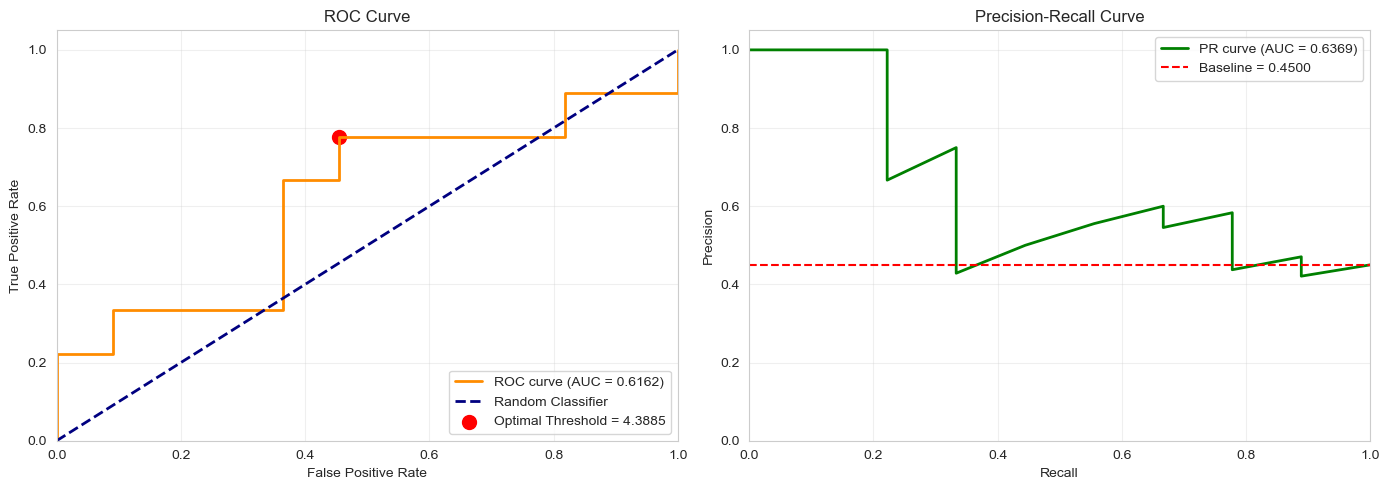

评估曲线已保存到 ambiguity_detection_evaluation.png

PR-AUC (Precision-Recall AUC): 0.6369


: 

In [ ]:
# 9. 可视化 ROC 曲线和 Precision-Recall 曲线
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC 曲线
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auroc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0].scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', s=100, 
                label=f'Optimal Threshold = {optimal_threshold:.4f}')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# Precision-Recall 曲线
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall_vals, precision_vals)

axes[1].plot(recall_vals, precision_vals, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
axes[1].axhline(y=np.sum(y_true) / len(y_true), color='red', linestyle='--', 
                label=f'Baseline = {np.sum(y_true) / len(y_true):.4f}')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc="upper right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ambiguity_detection_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("评估曲线已保存到 ambiguity_detection_evaluation.png")
print(f"\nPR-AUC (Precision-Recall AUC): {pr_auc:.4f}")

In [ ]:
# 10. 伪代码生成方法 - 使用Jina代码embedding模型评估歧义
print("加载Jina代码embedding模型...")
code_model_name = "jinaai/jina-code-embeddings-0.5b"

code_embedding_model = SentenceTransformer(
    code_model_name,
    tokenizer_kwargs={"padding_side": "left"},
)

print(f"代码embedding模型已加载")
print(f"模型名称: {code_model_name}")

In [8]:
# 12. 定义代码embedding函数
def get_code_embedding(code_text, model):
    """
    获取代码文本的embedding向量（使用SentenceTransformer）
    
    参数:
        code_text: 代码文本
        model: SentenceTransformer embedding模型
    
    返回:
        embedding: 代码embedding向量 (1, embedding_dim)
    """
    # 使用SentenceTransformer的encode方法，指定prompt为nl2code_document
    # 因为我们要编码代码/伪代码样本，不是查询
    embedding = model.encode(
        code_text,
        prompt_name="nl2code_document",
        convert_to_numpy=True
    )
    
    # 如果返回的是1D向量，需要reshape为2D
    if embedding.ndim == 1:
        embedding = embedding.reshape(1, -1)
    
    return embedding

print("get_code_embedding 函数已定义")

get_code_embedding 函数已定义


In [9]:
# 13. 定义计算伪代码相似度分数的函数
def calculate_pseudocode_similarity_score(pseudocodes, model):
    """
    计算伪代码批次的相似度分数
    
    使用与Clarification Score相同的逻辑，但基于代码embedding而非文本embedding
    
    公式: g(P_i^(q)) = ∑_{(p_ij, p_ij') ∈ P_i^(q) × P_i^(q)} (1 - sim(p_ij, p_ij'))
    
    参数:
        pseudocodes: 伪代码列表
        model: SentenceTransformer代码embedding模型
    
    返回:
        score: 伪代码相似度分数（高分表示高歧义）
        similarity_matrix: 相似度矩阵 (n, n)
    """
    n = len(pseudocodes)
    
    if n < 2:
        return 0.0, np.array([[1.0]])
    
    # 1. 批量获取所有伪代码的embedding向量
    embeddings = model.encode(
        pseudocodes,
        prompt_name="nl2code_document",
        convert_to_numpy=True
    )  # 返回 (n, embedding_dim)
    
    # 2. 计算所有伪代码对的相似度矩阵
    similarity_matrix = cosine_similarity(embeddings)  # (n, n)
    
    # 3. 计算分数：所有非对角线相似度倒数和
    score = 0.0
    
    for i in range(n):
        for j in range(n):
            if i != j:
                dissimilarity = 1 - similarity_matrix[i][j]
                score += dissimilarity
    
    return score, similarity_matrix

print("calculate_pseudocode_similarity_score 函数已定义")

calculate_pseudocode_similarity_score 函数已定义


In [ ]:
# 14. 生成伪代码 - 为每个需求生成10份伪代码
# 使用前面的df_test数据（前10个故事）
pseudocode_results = []

print("开始生成伪代码...\n")

for index, row in df_test.iterrows():
    story_id = row['StoryID']
    story_text = row['StoryText']
    pseudocodes = []
    
    print(f"处理故事 {index + 1}/{len(df_test)}: {story_id}")
    
    # 为该故事生成10份伪代码
    for attempt in range(10):
        # 使用导入的模板，通过 format() 替换 {REQUIREMENT} 占位符
        formatted_prompt = PSEUDOCODE_PROMPT_TEMPLATE.format(REQUIREMENT=story_text)
        
        try:
            response = client.chat(model='gpt-oss:20b', messages=[
                {
                    'role': 'user',
                    'content': formatted_prompt,
                },
            ])
            pseudocode = response.message.content
            pseudocodes.append(pseudocode)
            print(f"  生成伪代码 {attempt + 1}/10")
        except Exception as e:
            print(f"  生成伪代码 {attempt + 1}/10 失败: {str(e)}")
            pseudocodes.append(f"Error: {str(e)}")
    
    # 计算该故事的伪代码相似度分数
    if all(not pc.startswith("Error") for pc in pseudocodes):
        try:
            score, similarity_matrix = calculate_pseudocode_similarity_score(
                pseudocodes,
                code_embedding_model
            )
            pseudocode_ambiguity_level = 'High' if score > 5 else ('Medium' if score > 2 else 'Low')
        except Exception as e:
            print(f"  计算相似度分数失败: {str(e)}")
            score = 0.0
            similarity_matrix = np.array([[1.0]])
            pseudocode_ambiguity_level = 'Error'
    else:
        score = 0.0
        similarity_matrix = np.array([[1.0]])
        pseudocode_ambiguity_level = 'Error'
    
    pseudocode_results.append({
        'StoryID': story_id,
        'StoryText': story_text,
        'HasAmbiguity': row['HasAmbiguity'],
        'NumPseudocodes': len(pseudocodes),
        'PseudocodeScore': score,
        'PseudocodeAmbiguityLevel': pseudocode_ambiguity_level,
        'Pseudocodes': pseudocodes
    })
    
    print(f"  相似度分数: {score:.4f}, 歧义级别: {pseudocode_ambiguity_level}\n")

print(f"完成生成 {len(pseudocode_results)} 个故事的伪代码")

In [ ]:
# 15. 伪代码方法的评估 - 仅计算AUROC和F1分数
pseudocode_scores_df = pd.DataFrame(pseudocode_results)

# 为伪代码结果添加真实标签
pseudocode_scores_df['TrueLabel'] = pseudocode_scores_df['HasAmbiguity'].astype(int)

print(f"用于评估伪代码方法的样本数: {len(pseudocode_scores_df)}")
print(f"真实标签分布:")
print(pseudocode_scores_df['TrueLabel'].value_counts())
print()

# 准备数据
y_true_pseudo = pseudocode_scores_df['TrueLabel'].values
y_scores_pseudo = pseudocode_scores_df['PseudocodeScore'].values

# 1. 计算 AUROC
auroc_pseudo = roc_auc_score(y_true_pseudo, y_scores_pseudo)
print(f"伪代码方法 - AUROC: {auroc_pseudo:.4f}")

# 获取ROC曲线
fpr_pseudo, tpr_pseudo, roc_thresholds_pseudo = roc_curve(y_true_pseudo, y_scores_pseudo)

# 2. 寻找最优阈值
j_scores_pseudo = tpr_pseudo - fpr_pseudo
optimal_idx_pseudo = np.argmax(j_scores_pseudo)
optimal_threshold_pseudo = roc_thresholds_pseudo[optimal_idx_pseudo]

print(f"最优阈值（基于约登指数）: {optimal_threshold_pseudo:.4f}")

# 3. 进行二分类
y_pred_pseudo = (y_scores_pseudo >= optimal_threshold_pseudo).astype(int)

# 4. 计算 F1 分数
f1_pseudo = f1_score(y_true_pseudo, y_pred_pseudo)
print(f"伪代码方法 - F1 Score: {f1_pseudo:.4f}")

# 5. 计算其他评估指标（用于可视化，但不在主要输出中突出）
accuracy_pseudo = accuracy_score(y_true_pseudo, y_pred_pseudo)
tn_p, fp_p, fn_p, tp_p = confusion_matrix(y_true_pseudo, y_pred_pseudo).ravel()
precision_pseudo = tp_p / (tp_p + fp_p) if (tp_p + fp_p) > 0 else 0
recall_pseudo = tp_p / (tp_p + fn_p) if (tp_p + fn_p) > 0 else 0

# 6. Precision-Recall 曲线
precision_vals_pseudo, recall_vals_pseudo, pr_thresholds_pseudo = precision_recall_curve(y_true_pseudo, y_scores_pseudo)
pr_auc_pseudo = auc(recall_vals_pseudo, precision_vals_pseudo)

print("\n" + "="*50)
print(f"\n总结:")
print(f"  AUROC: {auroc_pseudo:.4f}")
print(f"  F1 Score: {f1_pseudo:.4f}\n")
print("="*50)

In [ ]:
# 16. 对比两种方法 - 消歧 vs 伪代码（简化版：仅AUROC和F1）
comparison_data = {
    'Method': ['Disambiguation', 'Pseudocode'],
    'AUROC': [auroc, auroc_pseudo],
    'F1 Score': [f1, f1_pseudo]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*70)
print("两种方法的核心指标对比")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# 创建简化的对比可视化 - 仅AUROC和F1
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

metrics = ['AUROC', 'F1 Score']
values_disambiguation = [auroc, f1]
values_pseudocode = [auroc_pseudo, f1_pseudo]
x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0].bar(x - width/2, values_disambiguation, width, label='Disambiguation', alpha=0.8, color='steelblue')
bars2 = axes[0].bar(x + width/2, values_pseudocode, width, label='Pseudocode', alpha=0.8, color='coral')

axes[0].set_ylabel('Score', fontsize=11)
axes[0].set_title('两种方法的性能对比', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].set_ylim([0, 1.0])
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# 添加数值标签
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 第二个图：差异对比
differences = [auroc - auroc_pseudo, f1 - f1_pseudo]
colors = ['green' if d > 0 else 'red' for d in differences]

bars = axes[1].bar(metrics, differences, color=colors, alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_ylabel('差异值 (消歧方法 - 伪代码方法)', fontsize=11)
axes[1].set_title('性能差异（正值表示消歧方法更优）', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# 添加数值标签
for bar, diff in zip(bars, differences):
    height = bar.get_height()
    label_y = height + 0.01 if height > 0 else height - 0.03
    axes[1].text(bar.get_x() + bar.get_width()/2., label_y,
               f'{diff:+.4f}', ha='center', va='bottom' if height > 0 else 'top', 
               fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('method_comparison_auroc_f1.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n对比图已保存到 method_comparison_auroc_f1.png")

In [ ]:
# 17. ROC和PR曲线对比
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC曲线对比
axes[0].plot(fpr, tpr, color='darkorange', lw=2.5, label=f'Disambiguation (AUROC = {auroc:.4f})')
axes[0].plot(fpr_pseudo, tpr_pseudo, color='blue', lw=2.5, label=f'Pseudocode (AUROC = {auroc_pseudo:.4f})')
axes[0].plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--', label='Random Classifier')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=11)
axes[0].set_ylabel('True Positive Rate', fontsize=11)
axes[0].set_title('ROC Curve Comparison', fontsize=12, fontweight='bold')
axes[0].legend(loc="lower right", fontsize=10)
axes[0].grid(True, alpha=0.3)

# Precision-Recall曲线对比
axes[1].plot(recall_vals, precision_vals, color='green', lw=2.5, label=f'Disambiguation (PR-AUC = {pr_auc:.4f})')
axes[1].plot(recall_vals_pseudo, precision_vals_pseudo, color='red', lw=2.5, label=f'Pseudocode (PR-AUC = {pr_auc_pseudo:.4f})')
baseline = np.sum(y_true) / len(y_true)
axes[1].axhline(y=baseline, color='gray', linestyle='--', lw=1.5, label=f'Baseline = {baseline:.4f}')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall', fontsize=11)
axes[1].set_ylabel('Precision', fontsize=11)
axes[1].set_title('Precision-Recall Curve Comparison', fontsize=12, fontweight='bold')
axes[1].legend(loc="upper right", fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_pr_curve_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("ROC和PR曲线对比已保存到 roc_pr_curve_comparison.png")

In [ ]:
# 18. 伪代码案例分析
def analyze_pseudocode_case(story_id, pseudocode_results, model):
    """
    分析单个故事的伪代码生成结果
    """
    # 找到对应的结果
    result = None
    for r in pseudocode_results:
        if r['StoryID'] == story_id:
            result = r
            break
    
    if not result:
        print(f"未找到故事 {story_id}")
        return
    
    print(f"\n{'='*80}")
    print(f"故事ID: {story_id}")
    print(f"故事文本: {result['StoryText']}")
    print(f"真实标签: {'有歧义' if result['HasAmbiguity'] else '无歧义'}")
    print(f"伪代码相似度分数: {result['PseudocodeScore']:.4f}")
    print(f"预测歧义级别: {result['PseudocodeAmbiguityLevel']}")
    print(f"{'='*80}\n")
    
    # 显示前3份伪代码
    pseudocodes = result['Pseudocodes']
    print("前3份生成的伪代码:")
    for i, pc in enumerate(pseudocodes[:3], 1):
        print(f"\n伪代码 {i}:")
        print("-" * 60)
        # 只显示前200个字符
        if len(pc) > 200:
            print(pc[:200] + "...")
        else:
            print(pc)
    
    # 计算相似度矩阵
    score, similarity_matrix = calculate_pseudocode_similarity_score(
        pseudocodes, model
    )
    
    print(f"\n伪代码相似度矩阵:")
    sim_df = pd.DataFrame(
        similarity_matrix,
        index=[f'P{i+1}' for i in range(len(pseudocodes))],
        columns=[f'P{i+1}' for i in range(len(pseudocodes))]
    )
    print(sim_df.round(3))
    
    # 可视化相似度矩阵
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, annot=True, fmt='.2f', cmap='RdYlGn', 
                xticklabels=[f'P{i+1}' for i in range(len(pseudocodes))],
                yticklabels=[f'P{i+1}' for i in range(len(pseudocodes))],
                cbar_kws={'label': '代码相似度'}, vmin=0, vmax=1)
    plt.title(f'伪代码相似度矩阵 - {story_id}')
    plt.tight_layout()
    plt.savefig(f'pseudocode_similarity_{story_id}.png', dpi=150, bbox_inches='tight')
    plt.show()

# 分析示例故事
print("分析示例故事的伪代码生成结果\n")
for result in pseudocode_results[:3]:  # 分析前3个故事
    analyze_pseudocode_case(
        result['StoryID'],
        pseudocode_results,
        code_embedding_model
    )

In [ ]:
# 19. 实验总结和结论 - 重点对比 AUROC 和 F1
print("\n" + "="*80)
print("CLARA 消歧 vs 伪代码方法 - 关键指标对比")
print("="*80 + "\n")

print("实验设置:")
print(f"  - 数据集: {len(df_test)} 个用户故事")
print(f"  - 消歧方法: 生成澄清文本 (BERT-base-uncased embedding)")
print(f"  - 伪代码方法: 生成伪代码 (Salesforce/SFR-Embedding-Code-400M_R embedding)")
print(f"  - 样本数: 每个需求生成10个样本")
print(f"  - 相似度指标: 余弦相似度")
print(f"  - 歧义分数: 所有配对的反相似性之和\n")

print("="*80)
print("关键指标对比")
print("="*80 + "\n")

# 创建简化的对比表
metrics_comparison = pd.DataFrame({
    'Method': ['消歧方法 (Disambiguation)', '伪代码方法 (Pseudocode)'],
    'AUROC': [f'{auroc:.4f}', f'{auroc_pseudo:.4f}'],
    'F1 Score': [f'{f1:.4f}', f'{f1_pseudo:.4f}']
})

print(metrics_comparison.to_string(index=False))
print("\n" + "="*80 + "\n")

# 计算性能差异
auroc_diff = auroc - auroc_pseudo
f1_diff = f1 - f1_pseudo

print("性能差异分析:")
print("-" * 80)
print(f"\n1. AUROC 差异: {auroc_diff:.4f}")
if auroc_diff > 0:
    print(f"   ✓ 消歧方法优于伪代码方法，提升 {abs(auroc_diff):.4f}")
elif auroc_diff < 0:
    print(f"   ✓ 伪代码方法优于消歧方法，提升 {abs(auroc_diff):.4f}")
else:
    print(f"   = 两种方法性能相同")

print(f"\n2. F1 Score 差异: {f1_diff:.4f}")
if f1_diff > 0:
    print(f"   ✓ 消歧方法优于伪代码方法，提升 {abs(f1_diff):.4f}")
elif f1_diff < 0:
    print(f"   ✓ 伪代码方法优于消歧方法，提升 {abs(f1_diff):.4f}")
else:
    print(f"   = 两种方法性能相同")

print("\n" + "="*80)
print("综合结论:")
print("="*80 + "\n")

if auroc > auroc_pseudo and f1 > f1_pseudo:
    print(f"✓ 消歧方法在AUROC和F1两个指标上都优于伪代码方法")
    print(f"  - AUROC: {auroc:.4f} (vs {auroc_pseudo:.4f}, +{auroc_diff:.4f})")
    print(f"  - F1:    {f1:.4f} (vs {f1_pseudo:.4f}, +{f1_diff:.4f})")
    print(f"\n  建议: 采用消歧方法作为主要的歧义检测方法")
elif auroc_pseudo > auroc and f1_pseudo > f1:
    print(f"✓ 伪代码方法在AUROC和F1两个指标上都优于消歧方法")
    print(f"  - AUROC: {auroc_pseudo:.4f} (vs {auroc:.4f}, +{abs(auroc_diff):.4f})")
    print(f"  - F1:    {f1_pseudo:.4f} (vs {f1:.4f}, +{abs(f1_diff):.4f})")
    print(f"\n  建议: 采用伪代码方法作为主要的歧义检测方法")
else:
    print(f"◇ 两种方法各有优势：")
    print(f"  - AUROC: {'消歧方法' if auroc > auroc_pseudo else '伪代码方法'} 更优 ({max(auroc, auroc_pseudo):.4f})")
    print(f"  - F1:    {'消歧方法' if f1 > f1_pseudo else '伪代码方法'} 更优 ({max(f1, f1_pseudo):.4f})")
    print(f"\n  建议: 考虑融合两种方法(Ensemble)以获得更好的性能")

print("\n" + "="*80 + "\n")

分析示例用户故事...


故事ID: US-C5-9039
故事文本: As a investor, I want to handle finances in order to track spending
澄清数量: 10
Clarification Score: 5.0336
歧义级别: High

澄清项:
1. As an investor, I want a dashboard that aggregates all of my investment accounts...
2. As an investor, I want to import my bank statements and have the system automati...
3. As an investor, I want to set spending limits for each investment category (e.g....
4. As an investor, I want automated alerts when my spending on a particular investm...
5. As an investor, I want a historical expense report that includes tax‑deductible ...
6. As an investor, I want to link my brokerage accounts and track fees and commissi...
7. As an investor, I want to create and manage multiple investment portfolios with ...
8. As an investor, I want visual charts (pie, bar, line) that display my spending o...
9. As an investor, I want to set up recurring expense entries (e.g., subscription f...
10. As an investor, I want the ability to export my spendi

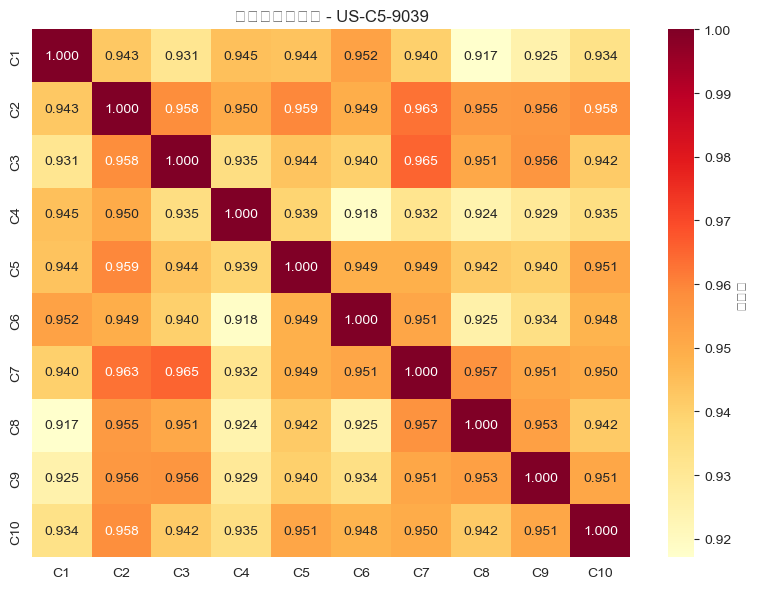


故事ID: US-C3-6636
故事文本: As a seller, I would like to track order to find desired items with detailed specifications and comprehensive requirements
澄清数量: 10
Clarification Score: 4.2521
歧义级别: Medium

澄清项:
1. As a seller, I want a real‑time order tracking dashboard that displays the curre...
2. As a seller, I want a search function that lets me filter orders by product spec...
3. As a seller, I want automated compliance checks that verify each ordered item me...
4. As a seller, I want a reporting tool that aggregates order data and highlights t...
5. As a seller, I want a notification system that alerts me when an order contains ...
6. As a seller, I want a multi‑attribute filter that allows me to view orders conta...
7. As a seller, I want a historical analytics module that tracks how often specific...
8. As a seller, I want an integration layer that pulls detailed product specificati...
9. As a seller, I want a validation workflow that requires confirmation that each i...
10. As a selle

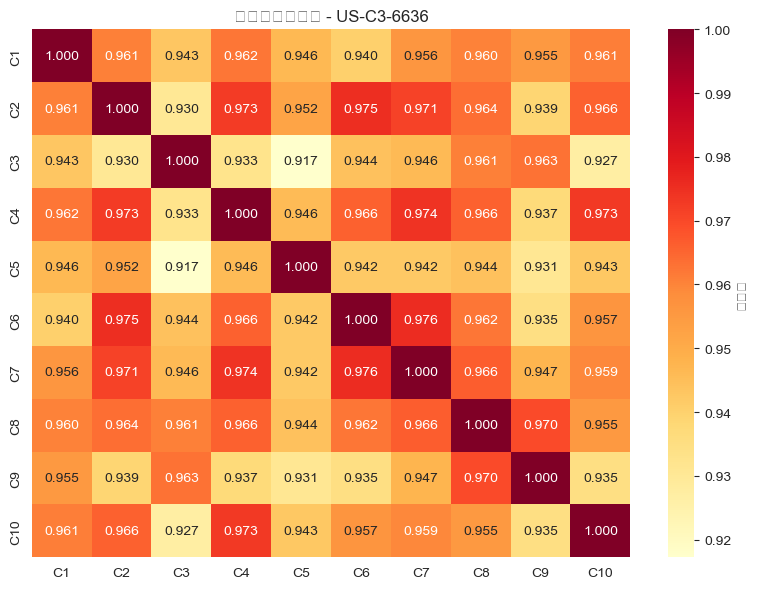

In [ ]:
# 7. 详细案例分析：显示澄清和相似度矩阵
def analyze_clarification_case(story_id, parsed_results, clarification_scores_list, 
                               tokenizer, model, device):
    """
    分析单个用户故事的澄清和相似度
    
    参数:
        story_id: 故事ID
        parsed_results: 解析结果列表
        clarification_scores_list: 澄清分数列表
        tokenizer: BERT分词器
        model: BERT模型
        device: 计算设备
    """
    # 找到相应的解析结果和分数
    parsed_result = None
    score_result = None
    
    for pr in parsed_results:
        if pr['StoryID'] == story_id:
            parsed_result = pr
            break
    
    for sr in clarification_scores_list:
        if sr['StoryID'] == story_id:
            score_result = sr
            break
    
    if not parsed_result or not score_result:
        print(f"未找到故事 {story_id}")
        return
    
    disambiguations = parsed_result['Disambiguations']
    
    print(f"\n{'='*80}")
    print(f"故事ID: {story_id}")
    print(f"故事文本: {parsed_result['StoryText']}")
    print(f"澄清数量: {len(disambiguations)}")
    print(f"Clarification Score: {score_result['ClarificationScore']:.4f}")
    print(f"歧义级别: {score_result['AmbiguityLevel']}")
    print(f"{'='*80}\n")
    
    print("澄清项:")
    for i, disambiguation in enumerate(disambiguations, 1):
        print(f"{i}. {disambiguation[:80]}...")
    
    # 计算并显示相似度矩阵
    if len(disambiguations) > 1:
        score, similarity_matrix = calculate_clarification_score(
            disambiguations, tokenizer, model, device
        )
        
        print(f"\n相似度矩阵:")
        # 创建一个更友好的相似度矩阵显示
        sim_df = pd.DataFrame(
            similarity_matrix,
            index=[f'C{i+1}' for i in range(len(disambiguations))],
            columns=[f'C{i+1}' for i in range(len(disambiguations))]
        )
        print(sim_df.round(3))
        
        # 可视化相似度矩阵
        plt.figure(figsize=(8, 6))
        sns.heatmap(similarity_matrix, annot=True, fmt='.3f', cmap='YlOrRd', 
                    xticklabels=[f'C{i+1}' for i in range(len(disambiguations))],
                    yticklabels=[f'C{i+1}' for i in range(len(disambiguations))],
                    cbar_kws={'label': '相似度'})
        plt.title(f'澄清相似度矩阵 - {story_id}')
        plt.tight_layout()
        plt.savefig(f'similarity_matrix_{story_id}.png', dpi=150, bbox_inches='tight')
        plt.show()

# 选择几个高、中、低歧义的案例进行分析
high_ambiguity = scores_df[scores_df['AmbiguityLevel'] == 'High'].head(1)
medium_ambiguity = scores_df[scores_df['AmbiguityLevel'] == 'Medium'].head(1)
low_ambiguity = scores_df[scores_df['AmbiguityLevel'] == 'Low'].head(1)

example_stories = []
if len(high_ambiguity) > 0:
    example_stories.append(high_ambiguity.iloc[0]['StoryID'])
if len(medium_ambiguity) > 0:
    example_stories.append(medium_ambiguity.iloc[0]['StoryID'])
if len(low_ambiguity) > 0:
    example_stories.append(low_ambiguity.iloc[0]['StoryID'])

print("分析示例用户故事...\n")
for story_id in example_stories:
    analyze_clarification_case(
        story_id, 
        parsed_results, 
        clarification_scores,
        tokenizer, 
        bert_model, 
        device
    )